In [1]:
from  scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
import pandas as pd
import runner
import umm
from imp import reload
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True


NameError: name 'matplotlib' is not defined

In [ ]:
reload(runner)
instance_name="LOP-synthetic,seed=123456,n=20,m=200,phi=0.9"
# instance_name="pfsp/rec19.txt"
# instance_name="lop/xLOLIB/N-be75eec_150"
# instance_name="lop/xLOLIB/N-be75eec_150"
# instance_name="qap/nug12.dat"
budgetGA=5
seed=2
budget=200
m_ini=10
budgetMM=10
# ratio_samples_learn=0.10
# weight_mass_learn=0.9
res = []
np.set_printoptions(linewidth=np.nan)
for ratio_samples_learn in [.1]:
  for weight_mass_learn in [0.9]:
    out_filename = "pickles/"+instance_name.replace("/", "__").replace(".txt", "")
    df = runner.run_once("uMM", instance_name, seed,budget = budget, m_ini = m_ini, budgetMM = budgetMM, 
                         ratio_samples_learn = ratio_samples_learn, weight_mass_learn = weight_mass_learn, out_filename = out_filename)
    res.append([out_filename,ratio_samples_learn, weight_mass_learn,df.Fitness.min()])
    print("best found",df.Fitness.min())
    #out_filename="local_new_CEGO"
    #runner.run_once("CEGO", instance_name, seed,budget = budget, m_ini = m_ini, budgetGA = budgetGA, out_filename = out_filename)

In [ ]:
# instance_name="pfsp/rec05.txt"
out_file = "pickles/"+instance_name.replace("/", "__").replace(".txt", "")
df = pd.read_pickle(out_filename+'.pkl.gz')
#dfc, dfu = pd.read_pickle('local_new_CEGO.pkl.gz'),pd.read_pickle('local_new_uMM.pkl.gz');df = pd.concat([dfc, dfu]) 

print("instance name", df.instance.iloc[0], "- time", round(df.run_time.iloc[0], 2))
sns.set_style("whitegrid")
print(df.Fitness.min())
# 'pickles/pickLocal.pkl')#pick570618.pkl

color_variable = 'Solver'
y_variables = ['Fitness']#,'Distance','phi_sample'
palette = sns.color_palette("husl", len(df[color_variable].drop_duplicates()))
for y_variable in y_variables:
    plt.figure(figsize=(15,5))
    sns.lineplot(x='Function evaluations',y=y_variable,hue='Solver',data=df, palette=palette)
    plt.show()

# Real data umm

we have executed umm with a grid of parameters ratio_samples_learn & weight_samples_learn. We load the min found in the execution in `df` and the best known solutions in `best`. (The best know for the real data LOP are give as a maximitaion problem so this value has to be corrected)



In [ ]:
find_in_lop_folder('N-be75eec', ret_value='path'),find_in_lop_folder('N-be75eec_150', ret_value='path')

In [ ]:
def find_in_lop_folder(instance_name, ret_value='instance'):
  import os
  for fol in os.listdir("lop"):
    if os.path.isdir("lop/"+fol):
      for file in os.listdir("lop/"+fol):
          if instance_name == file:
              path = "lop/"+fol+"/"+file
              with open(path) as f:
                n = int(f.readline().strip())
                instance = np.loadtxt(f, max_rows=n)
              if ret_value == 'instance' : return instance
              if ret_value == 'path': return path
  return None
#find_in_lop_folder('N-t1d100.01')

def get_best_know():
  best = pd.read_csv('lop/best_fitness_selected.txt',sep='\t')
## maximizar la de abajo o minimizar la de arriba, el plateamiento es distint, hay q ajustar los datos que nos dan del best_fval
  # cambia los de la carperta LOP 
  for instance_name in best.instance_name:
    inst = find_in_lop_folder(instance_name)
    if inst is not None:
      ins, be = inst.sum() , best[best.instance_name==instance_name].best_known_global.values[0] 
  #     print(ins, be)
      best.loc[best.instance_name==instance_name, 'best_known_global'] = ins - be 
  return best



## which ratio_samples_learn & weight_samples_learn is the best for each instance?

For the LOP instances (synthetic and real) the best fitness function changes smoothly when we change the parameters
For the QAP and PFSP this does not happen, meaning that the convergence to the optimal is not smooth

Overall, we can say that `ratio_samples_learn=0.1` and `weight_samples_learn=0.9` is a reasonable choice

N-atp111


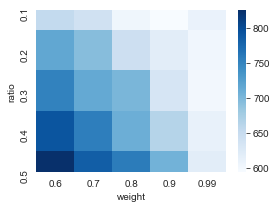

N-atp134


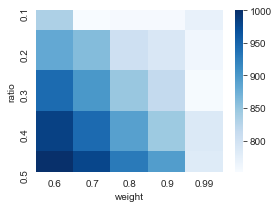

N-be75eec-150


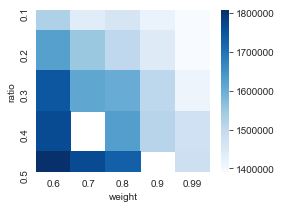

N-be75np-150


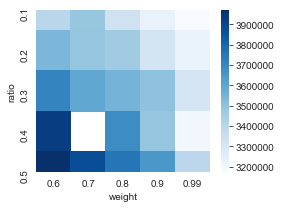

N-p50-01


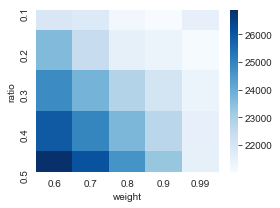

N-p50-02


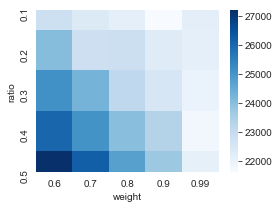

N-t1d100.01


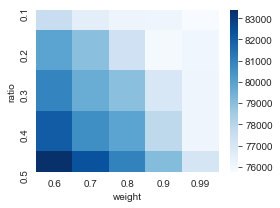

N-t1d100.02


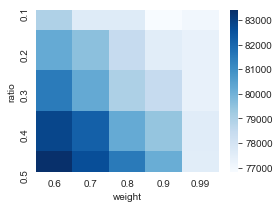

N-t1d150.01


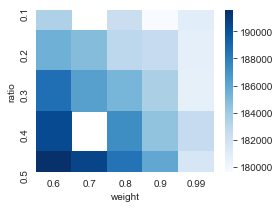

N-t1d150.02


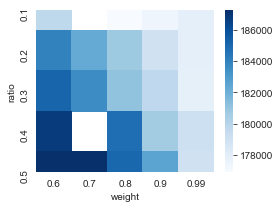

N-t2d150.01


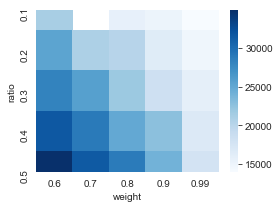

N-t2d150.02


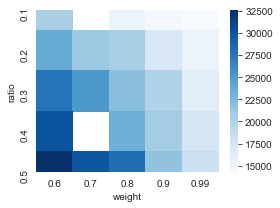

kra32.dat


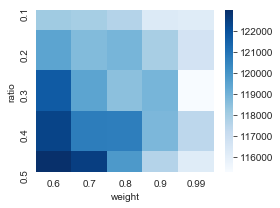

nug12.dat


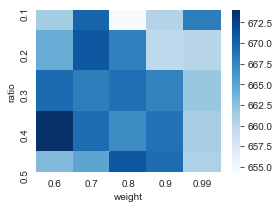

nug30.dat


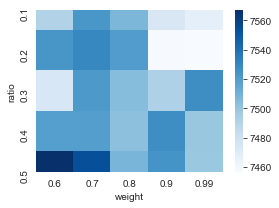

rec05


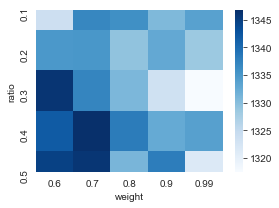

rec13


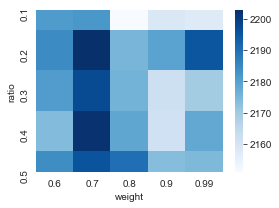

rec19


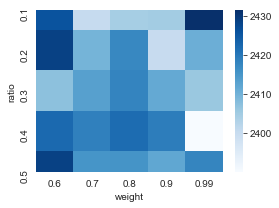

rec31


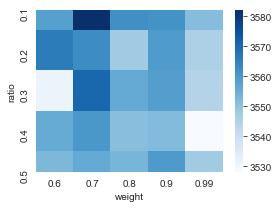

tho30.dat


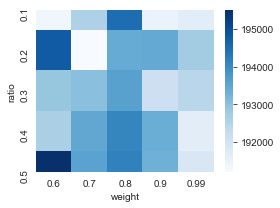

In [2]:
df = pd.read_csv('results/results.csv',index_col=0)
df.columns = [c if c!='min' else 'best' for c in df.columns]
df = pd.pivot_table(df,index=['filename','ratio','weight'],values='best',aggfunc={np.mean,np.min, np.std})#.reset_index()
df.columns = ['best_'+ c for c in df.columns]
dfres = df.reset_index()
dfres
for instance_name in dfres.filename.drop_duplicates().values:
  print(instance_name, )
  plt.figure(figsize=(4,3))
  sns.set_style("whitegrid")
  square = dfres[dfres.filename == instance_name].pivot_table(index='ratio', columns='weight', values='best_mean')
  sns.heatmap(square, cmap="Blues")
  plt.tight_layout()
  plt.savefig('img/heatmap_'+instance_name+'.pdf')

  plt.show()

## run best
run the best param configuration for each instance and plot the converge. The best parameters for a particular instance are given by `best_params = dfres.loc[dfres.groupby('instance_name').best_mean.idxmin()]`

In [ ]:
best_params = dfres.loc[dfres.groupby('instance_name').best_mean.idxmin()]


budgetGA=5
seed=2
budget=20
m_ini=10
budgetMM=10
for index, row in best_params.iterrows():
    print(row.filename, row.ratio, row.weight, row.best_known_global)
    if "N-" in row.filename: 
      instance_name, ratio_samples_learn, weight_mass_learn = row.filename, row.ratio, row.weight
      instance_name = find_in_lop_folder(instance_name, ret_value='path')
      
      out_filename = "pickles/"+instance_name.replace("/", "__").replace(".txt", "")
      out_file = "pickles/"+instance_name.replace("/", "__").replace(".txt", "")
      df = runner.run_once("uMM", instance_name, seed,budget = budget, m_ini = m_ini, budgetMM = budgetMM, 
                       ratio_samples_learn = ratio_samples_learn, weight_mass_learn = weight_mass_learn, out_filename = out_filename)
      sns.set_style("whitegrid")
      print(df.Fitness.min())
      color_variable = 'Solver'
      y_variables = ['Fitness']
      palette = sns.color_palette("husl", len(df[color_variable].drop_duplicates()))
      for y_variable in y_variables:
          plt.figure(figsize=(15,5))
          pl = sns.lineplot(x='Function evaluations',y=y_variable,hue='Solver',data=df, palette=palette)
          pl.set_title("Best known: "+str(row.best_known_global)+", time: "+ str(round(df.run_time.iloc[0], 2)))
          plt.savefig(out_filename.replace("pickles","img")+".jpg")
          plt.show()
    

# Compare CEGO and UMM
primrtoo QAP y PFSF, que hay de los dos y despues LOP, solo hay UMM

In [8]:

lis = []
for folder in ['results-loplib/', 'results/']  : 
  for filename in os.listdir(folder) :
    if 'pkl'in filename:
      lis.append(pd.read_pickle(folder+filename))
dfcego = pd.concat(lis)
dfumm = pd.concat([pd.read_pickle('pickles/'+filename) for filename in os.listdir('pickles') if 'pkl.gz'in filename])
dfumm['instance'] = dfumm['instance'].str[2:] #para quitar el punto barrra

Instance:  N-t1d100.01


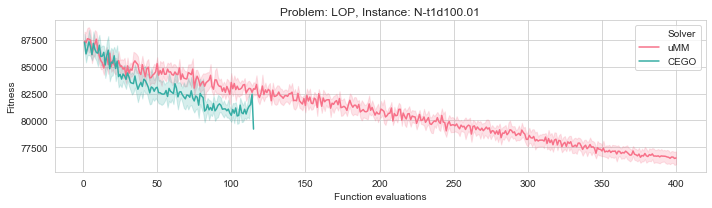

Instance:  N-t1d100.02


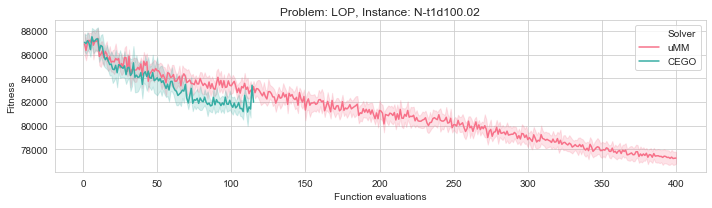

Instance:  N-t1d150.01


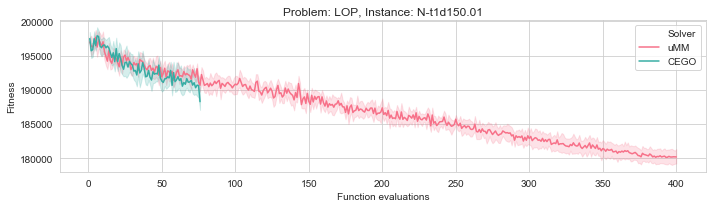

Instance:  N-t1d150.02


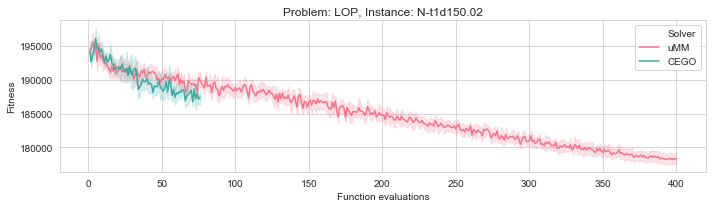

Instance:  N-t1d200.01


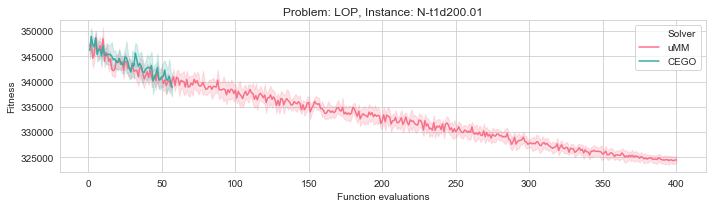

Instance:  N-t1d200.02


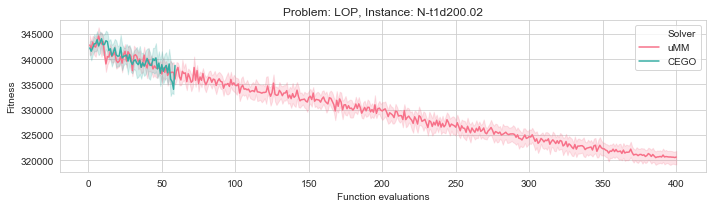

Instance:  N-t2d150.01


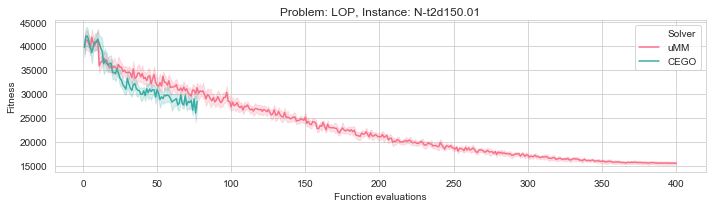

Instance:  N-t2d150.02


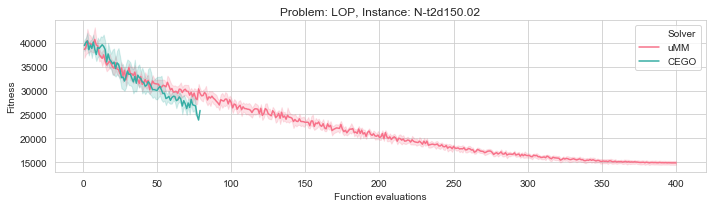

Instance:  N-t2d200.01


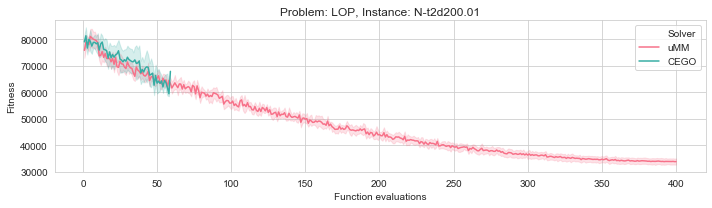

Instance:  N-t2d200.02


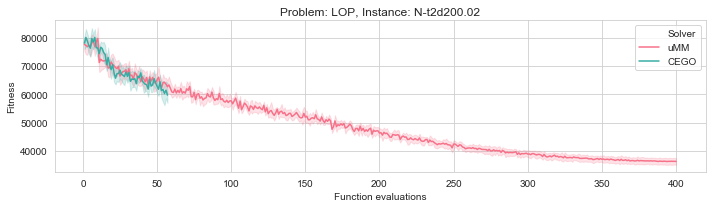

Instance:  N-p50-01


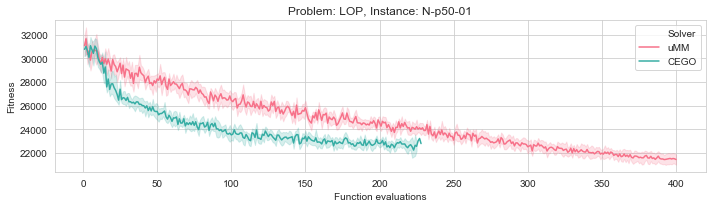

Instance:  N-p50-02


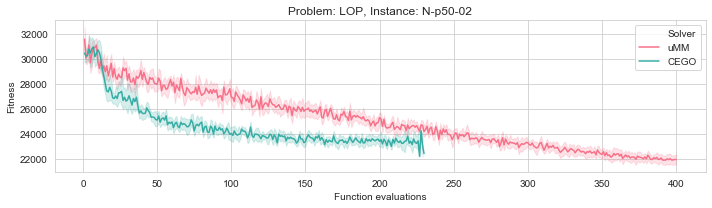

Instance:  N-be75eec_150


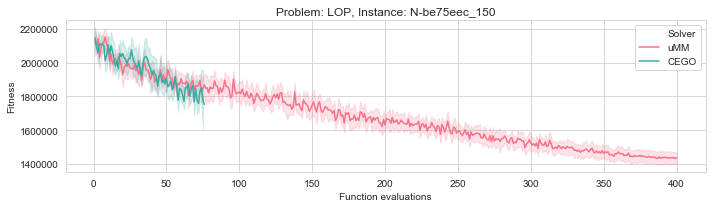

Instance:  N-be75np_150


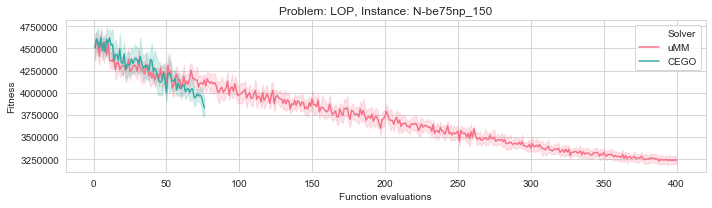

Instance:  N-be75eec_250


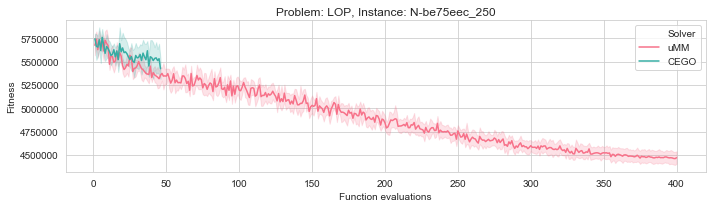

Instance:  N-be75np_250


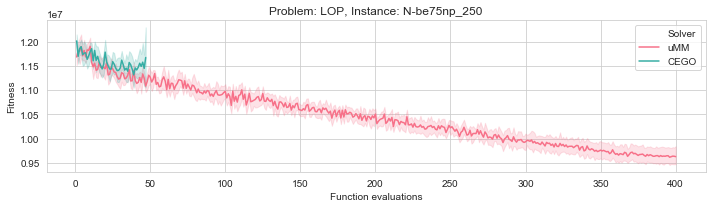

Instance:  N-atp111


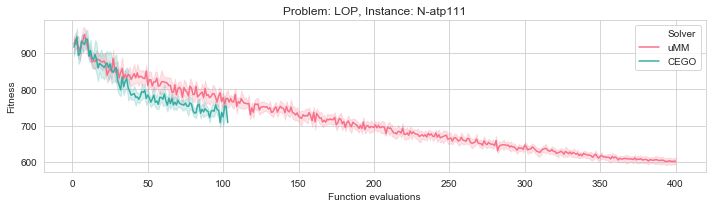

Instance:  N-atp134


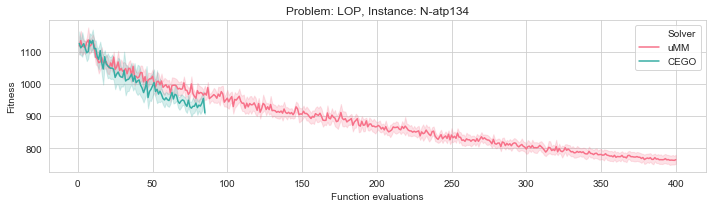

Instance:  tho30


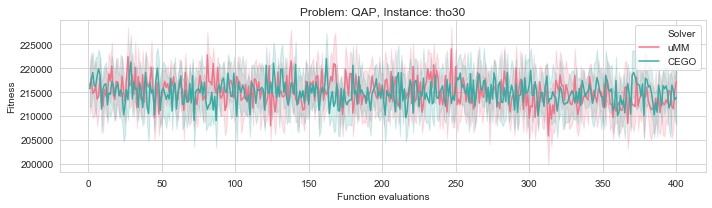

Instance:  kra32


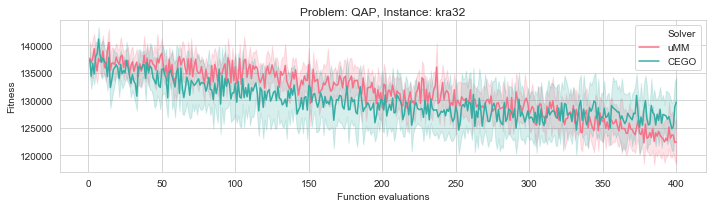

Instance:  nug30


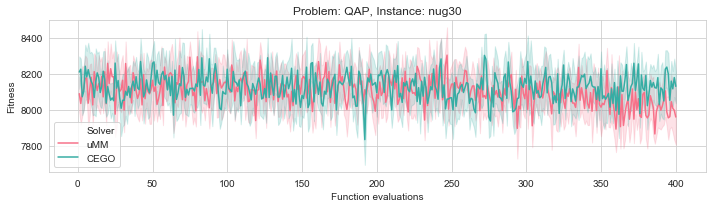

Instance:  nug12


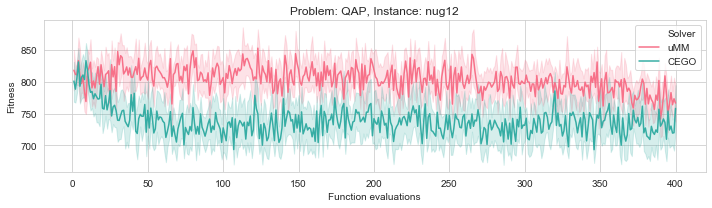

Instance:  rec05


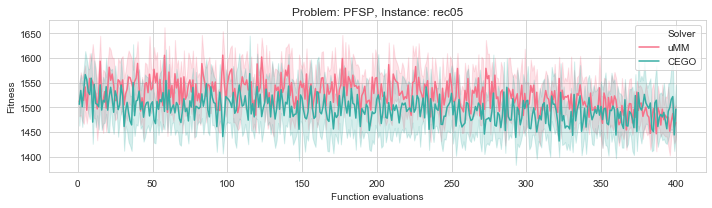

Instance:  rec13


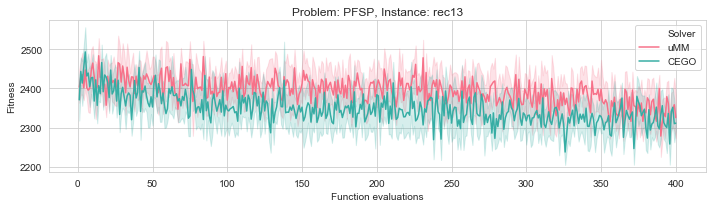

Instance:  rec19


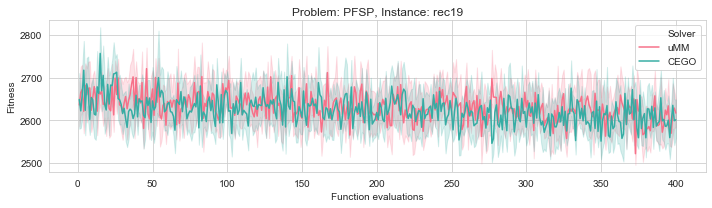

Instance:  rec31


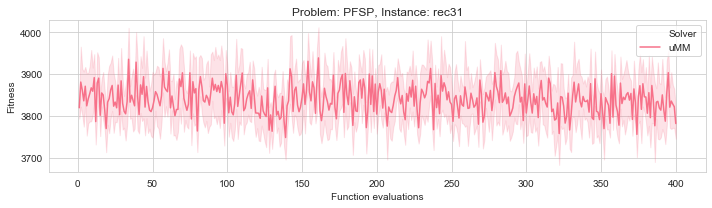

In [4]:
sns.set_style("whitegrid")
dfselected = pd.read_csv('lop/best_fitness_selected.txt',sep='\t')
dfselected
for inst in dfselected.instance_name.values:
  print("Instance: ",inst)
  df = pd.concat([dfumm[dfumm.instance.str.contains(inst)], dfcego[dfcego.instance.str.contains(inst)]],sort=False)
  if len(df)>0:
    plt.figure(figsize=(10,3))
    palette = sns.color_palette("husl", len(df['Solver'].drop_duplicates()))
    g = sns.lineplot(x='Function evaluations',y='Fitness',hue='Solver',data=df, palette=palette)
    g.set_title('Problem: '+df.Problem.iloc[0]+', Instance: '+ inst)
    plt.tight_layout()
    plt.savefig('img/fitness_real_'+df.instance.iloc[0].replace('/','_').replace('.','_')+'.pdf')
    plt.show()
#     print(kak)

ranking of the solvers by fitness
['uMM ' 'uMM ' 'uMM ' 'uMM ' 'CEGO' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM '
 'CEGO' 'CEGO' 'uMM ' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO']


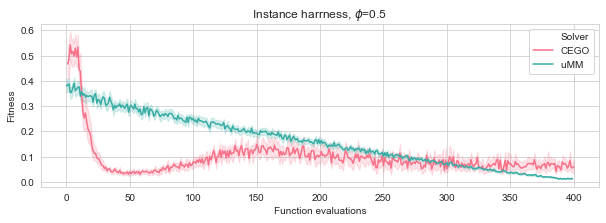

ranking of the solvers by fitness
['uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'CEGO' 'uMM '
 'uMM ' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'CEGO']


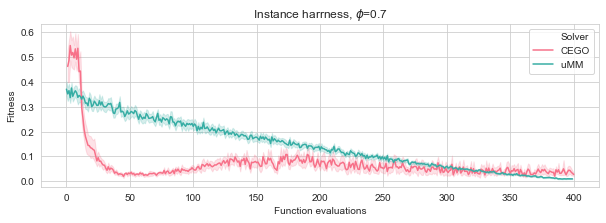

ranking of the solvers by fitness
['uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'uMM ' 'CEGO' 'CEGO' 'uMM '
 'CEGO' 'CEGO' 'CEGO' 'uMM ' 'CEGO' 'uMM ' 'CEGO' 'CEGO' 'CEGO' 'CEGO']


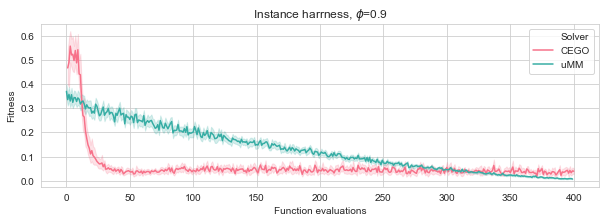

In [5]:

# COmpare in synthetic data
# Compare the convergence to lowest fitness funtion values by the two solvers

dfcego = pd.concat([pd.read_pickle('results/'+filename) for filename in os.listdir('results') for i in range(9,12) if 'pkl'in filename and 'cego-'+str(i)+'-' in filename],sort=False)
dfumm = pd.concat([pd.read_pickle('pickles/'+filename) for filename in os.listdir('pickles') if 'pkl'in filename and 'pick' in filename and 'pickCEGO.pkl' not in filename],sort=False)
dfumm.columns = [c if c!= 'Sample size' else 'Function evaluations' for c in dfumm.columns]
dfumm.columns = [c if c!= 'rep' else 'seed' for c in dfumm.columns]


for phi in [0.5, 0.7, 0.9]: 
  
  df = pd.concat([dfcego[dfcego.instance.str.contains('phi='+str(phi))], dfumm[dfumm.phi_instance==phi]],sort=False)
  sns.set_style("whitegrid")
  print("ranking of the solvers by fitness")
  print(df.groupby(['Solver','seed']).Fitness.min().reset_index().sort_values(by='Fitness').Solver.values)
  color_variable = 'Solver'
  y_variables = ['Fitness']#,'Distance','phi_sample'
  palette = sns.color_palette("husl", len(df[color_variable].drop_duplicates()))
  for y_variable in y_variables:
      plt.figure(figsize=(10,3))
      g = sns.lineplot(x='Function evaluations',y=y_variable,hue='Solver',data=df, palette=palette)
      g.set_title(r'Instance harrness, $\phi$='+str(phi))
      plt.savefig('img/fitness_phi_'+str(phi)+'.jpg')
      plt.show()


0    NaN
0    0.5
Name: phi_instance, dtype: float64 8000 4000 4000
0    NaN
0    0.7
Name: phi_instance, dtype: float64 8000 4000 4000
0    NaN
0    0.9
Name: phi_instance, dtype: float64 8000 4000 4000
ranking of the solvers by fitness
['uMM ' 'uMM ' 'uMM ' 'uMM ' 'CEGO' 'uMM ' 'CEGO' 'uMM ' 'uMM ' 'CEGO'
 'CEGO' 'uMM ' 'CEGO' 'CEGO' 'uMM ' 'CEGO' 'CEGO' 'CEGO' 'CEGO' 'uMM ']


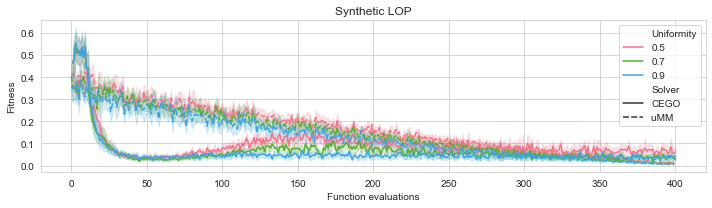

In [6]:

# COmpare in synthetic data in the same plot
# Compare the convergence to lowest fitness funtion values by the two solvers

dfcego = pd.concat([pd.read_pickle('results/'+filename) for filename in os.listdir('results') for i in range(9,12) if 'pkl'in filename and 'cego-'+str(i)+'-' in filename],sort=False)
dfumm = pd.concat([pd.read_pickle('pickles/'+filename) for filename in os.listdir('pickles') if 'pkl'in filename and 'pick' in filename and 'pickCEGO.pkl' not in filename],sort=False)
dfumm.columns = [c if c!= 'Sample size' else 'Function evaluations' for c in dfumm.columns]
dfumm.columns = [c if c!= 'rep' else 'seed' for c in dfumm.columns]

lis = []
for phi in [0.5, 0.7, 0.9]: 
  a = dfcego[dfcego.instance.str.contains('phi='+str(phi))]
  b = dfumm[(dfumm.phi_instance==phi) & (dfumm.ratio_samples_learn==0.1503) & (dfumm.weight_mass_learn==0.8362)]
  df = pd.concat([a,b ],sort=False)
  df['Uniformity'] = phi
  print(df.phi_instance.drop_duplicates(), len(df), len(a), len(b))
  lis.append(df)
  
df = pd.concat(lis)

sns.set_style("whitegrid")
print("ranking of the solvers by fitness")
print(df.groupby(['Solver','seed']).Fitness.min().reset_index().sort_values(by='Fitness').Solver.values)
color_variable = 'Uniformity'
y_variables = ['Fitness']#,'Distance','phi_sample'
palette = sns.color_palette("husl", len(df[color_variable].drop_duplicates()))
for y_variable in y_variables:
    plt.figure(figsize=(10,3))
    g = sns.lineplot(x='Function evaluations',y=y_variable,style='Solver', hue=color_variable,data=df, palette=palette)
    g.set_title('Synthetic LOP')
    plt.tight_layout()
    plt.savefig('img/synthetic_LOP_combined.pdf')
    plt.show()


Compare in the mean of min along each repetition
tiempos de ejec, intervalos de confianza

In [9]:
# tiempo medio y num medio de evaluaciones
a = dfcego.groupby(['Problem','instance','seed']).run_time.max().groupby(['Problem','instance']).mean().reset_index().round(1)
a['run_time'] = (a['run_time']/3600).round(1)
a.columns = ['Problem','instance','CEGO Runtime']
b = dfumm.groupby(['Problem','instance','seed']).run_time.max().groupby(['Problem','instance']).mean().reset_index().round(1)
b['run_time'] = (b['run_time']/3600).round(1)
b.columns = ['Problem','instance','UMM Runtime']
a
dftime = pd.merge(b,a)
dftime
a = dfcego.groupby(['Problem','instance','seed']).max()['Function evaluations'].groupby(['Problem','instance']).mean().reset_index()
a.columns = ['Problem','instance','CEGO F. evaluations']
dftime = pd.merge(dftime,a)
dftime


,Problem,instance,UMM Runtime,CEGO Runtime,CEGO F. evaluations
0,LOP,lop/RandA1/N-t1d100.01,3.2,72.5,111.8
1,LOP,lop/RandA1/N-t1d100.02,3.2,72.9,110.7
2,LOP,lop/RandA1/N-t1d150.01,6.5,72.7,73.9
3,LOP,lop/RandA1/N-t1d150.02,6.5,73.2,74.1
4,LOP,lop/RandA1/N-t1d200.01,10.7,73.2,55.6
5,LOP,lop/RandA1/N-t1d200.02,10.6,73.7,56.5
6,LOP,lop/RandA2/N-t2d150.01,7.0,72.9,74.6
7,LOP,lop/RandA2/N-t2d150.02,7.1,72.8,74.8
8,LOP,lop/RandA2/N-t2d200.01,11.2,73.3,56.3
9,LOP,lop/RandA2/N-t2d200.02,11.2,73.5,55.6


In [10]:
import numpy as np, statsmodels.stats.api as sms

a = dfcego.groupby(['Problem','instance','seed']).Fitness.min()
b = dfumm.groupby(['Problem','instance','seed']).Fitness.min()

aa = a.groupby(['Problem','instance']).agg(Fitness_CEGO_mean='mean', Fitness_CEGO_std='std').reset_index() 
bb = b.groupby(['Problem','instance']).agg(Fitness_UMM_mean='mean', Fitness_UMM_std='std').reset_index() 
df = pd.merge(aa,bb)
#df['Improvement'] = (df['Fitness_CEGO_mean'] - df['Fitness_UMM_mean'])/df['Fitness_CEGO_mean'] 
aa = a.reset_index()
bb = b.reset_index()
# df['ttest statistic'] = np.nan
# df['ttest pvalue'] = np.nan
for inst in df.instance:
  x,y = aa[aa.instance==inst].Fitness.values,bb[bb.instance==inst].Fitness.values
  cm = sms.CompareMeans(sms.DescrStatsW(x), sms.DescrStatsW(y))
#   print (tuple([i.round(1) for i in cm.tconfint_diff(usevar='unequal')]))
  df.loc[df.instance==inst,'Confidence interval'] = str(tuple([i.round(1) for i in cm.tconfint_diff(usevar='unequal')]))
#   df.loc[df.instance==inst,'ttest statistic'] = stats.ttest_ind(x,y)[0]
#   df.loc[df.instance==inst,'ttest pvalue'] = stats.ttest_ind(x,y)[1]
df['CEGO fitness'] = df.Fitness_CEGO_mean.round(1).astype(str)+" ("+df.Fitness_CEGO_std.round(1).astype(str)+")"
df['UMM fitness'] = df.Fitness_UMM_mean.round(1).astype(str)+" ("+df.Fitness_UMM_std.round(1).astype(str)+")"
df = df.drop(['Fitness_CEGO_mean'	,'Fitness_CEGO_std',	'Fitness_UMM_mean',	'Fitness_UMM_std'], axis=1)
df = pd.merge(df,dftime, on=['Problem', 'instance'])
df['Instance'] = [i[-1] for i in df.instance.str.split('/').values]
df = df[['Problem', 'Instance','UMM fitness', 'CEGO fitness',	'Confidence interval',	'UMM Runtime',	'CEGO Runtime',	'CEGO F. evaluations']]
df

,Problem,Instance,UMM fitness,CEGO fitness,Confidence interval,UMM Runtime,CEGO Runtime,CEGO F. evaluations
0,LOP,N-t1d100.01,76119.6 (915.4),78696.6 (811.4),"(1763.5, 3390.5)",3.2,72.5,111.8
1,LOP,N-t1d100.02,76827.7 (891.0),79686.5 (367.9),"(2194.5, 3523.1)",3.2,72.9,110.7
2,LOP,N-t1d150.01,179508.3 (1647.9),187605.5 (1906.9),"(6420.3, 9774.1)",6.5,72.7,73.9
3,LOP,N-t1d150.02,177592.8 (1196.2),184320.9 (973.5),"(5700.5, 7755.7)",6.5,73.2,74.1
4,LOP,N-t1d200.01,323513.6 (1371.2),335391.1 (2289.0),"(10076.1, 13678.9)",10.7,73.2,55.6
5,LOP,N-t1d200.02,319675.8 (2242.6),333149.5 (2497.2),"(11242.0, 15705.4)",10.6,73.7,56.5
6,LOP,N-t2d150.01,15297.7 (563.5),24682.7 (976.6),"(8622.2, 10147.8)",7.0,72.9,74.6
7,LOP,N-t2d150.02,14724.9 (667.5),24250.8 (1354.9),"(8495.1, 10556.7)",7.1,72.8,74.8
8,LOP,N-t2d200.01,33465.2 (2001.0),57098.6 (4452.8),"(20284.5, 26982.3)",11.2,73.3,56.3
9,LOP,N-t2d200.02,35901.8 (2077.5),54895.6 (4589.7),"(15539.1, 22448.5)",11.2,73.5,55.6


In [ ]:
print(df.to_latex(index=False))

# REAL LOP
10:41


In [11]:
from pathlib import Path
best = pd.read_csv('lop/best_fitness_selected.txt',sep='\t')
## maximizar la de abajo o minimizar la de arriba, el plateamiento es distint, hay q ajustar los datos que nos dan del best_fval
# cambia los de la carperta LOP 
for instance_name in best.instance_name:
  inst = find_in_lop_folder(instance_name)
  if inst is not None:
    ins, be = inst.sum() , best[best.instance_name==instance_name].best_known_global.values[0] 
    best.loc[best.instance_name==instance_name, 'best_known_global'] = ins - be 
best = best[best.instance_name.str.startswith('N-')]
best
for ind, row in best.iterrows():
  out_filename = find_in_lop_folder(row.instance_name, ret_value='path')
  print(out_filename)
  out_filename = "pickles/"+out_filename.replace("/", "__").replace(".txt", "")+'.pkl.gz'
  if not Path(out_filename).exists():
    print("NOT FINISHED",out_filename)
  else:
    print(out_filename)
    df = pd.read_pickle(out_filename)
    sns.set_style("whitegrid")
  #   print("ranking of the solvers by fitness")
  #   print(df.groupby(['Solver','seed']).Fitness.min().reset_index().sort_values(by='Fitness').Solver.values)
    color_variable = 'Solver'
    y_variables = ['Fitness']#,'Distance','phi_sample'
    palette = sns.color_palette("husl", len(df[color_variable].drop_duplicates()))
    if df['Function evaluations'].max() >350:
      for y_variable in y_variables:
          plt.figure(figsize=(15,5))
          g = sns.lineplot(x='Function evaluations',y=y_variable,hue='Solver',data=df, palette=palette)
          g.plot([0, 400], [row.best_known_global, row.best_known_global], linewidth=2)
    #       g.set_title(r'Instance harrness, $\phi$='+str(phi))
    #       plt.savefig('img/fitness_phi_'+str(phi)+'.jpg')
          plt.show()


NameError: name 'find_in_lop_folder' is not defined

In [ ]:

df = pd.read_pickle('pickles/lop__xLOLIB__N-be75np_250.pkl.gz')
df.run_time.iloc[0]/3600